In [29]:
import os

import numpy as np
import qiskit
import qiskit.ignis.mitigation.measurement as mc
from dotenv import load_dotenv
from numpy import pi
from qiskit import (IBMQ, Aer, ClassicalRegister, QuantumCircuit,
                    QuantumRegister, execute, transpile)
from qiskit.ignis.verification.tomography import (StateTomographyFitter,
                                                  state_tomography_circuits)
from qiskit.providers.aer import AerSimulator, noise
from qutip import Bloch, Qobj

from sync_gates import add_tomography
from sync_plots import calc_and_plot_Q_and_S

load_dotenv()



True

## Credentials/Backend

In [30]:
# IBMQ.ibmq.save_account(os.environ['TOKEN'], overwrite=True)
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-10 14:22:53,196: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [31]:
provider = IBMQ.get_provider(group='open', project='main')

backend = provider.get_backend('ibmq_quito')
sim = AerSimulator.from_backend(backend)

provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

## Parameters

In [32]:
gain_amp = 1
loss_amp = 0.1
m = min(loss_amp, gain_amp)

detuning = 3 * m
signal_strength = 2 * m
dt = 0.5

theta_d = 2 * np.arcsin(np.sqrt(loss_amp * dt))
theta_g = 2 * np.arcsin(np.sqrt(gain_amp * dt))

## Circuit

In [33]:
z_arg = -detuning * dt / 2
y_arg = -signal_strength * dt

qreg_q = QuantumRegister(2, "q")
creg_c = ClassicalRegister(1, "c")

qc = QuantumCircuit(qreg_q, creg_c)

for _ in range(35):
    qc.u(z_arg, y_arg, z_arg, qreg_q[0])

    # Loss
    qc.cu(theta_d, 0, 0, 0, qreg_q[0], qreg_q[1])
    qc.cx(qreg_q[1], qreg_q[0])
    qc.measure(qreg_q[1], creg_c[0])
    qc.reset(qreg_q[1])

    # Gain
    qc.u(-pi, 0, 0, qreg_q[0])
    qc.cx(qreg_q[0], qreg_q[1])
    qc.cu(theta_g, 0, 0, 0, qreg_q[0], qreg_q[1])
    qc.cx(qreg_q[0], qreg_q[1])
    qc.u(pi, 0, 0, qreg_q[0])
    qc.measure(qreg_q[1], creg_c[0])
    qc.reset(qreg_q[1])

# qc.measure_all()

# qc.draw(fold=150)


## Tomography Setup

In [34]:
# qpt_circs1 = state_tomography_circuits(qc, qreg_q[0])  # Causes problems with noise mitigation
qpt_circs = list(add_tomography(qc))

## Simulation

### Calibration Circuit

In [35]:
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0])
job_cal = sim.run(meas_calibs, shots=8192)

meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels)
meas_fitter.cal_matrix

array([[0.98498535, 0.0715332 ],
       [0.01501465, 0.9284668 ]])

### Main Circuit with Noise

In [36]:
qpt_circs_compiled = transpile(qpt_circs, sim)
job_tomo = sim.run(qpt_circs_compiled, shots=8192)

result = job_tomo.result()

tomo_state = StateTomographyFitter(result, qpt_circs)

In [37]:
# from qiskit.visualization import plot_histogram
# counts = job_tomo.result().get_counts()
# plot_histogram(counts)


## Tomography

In [38]:
# no correction
state = tomo_state.fit()
# F_state = qi.state_fidelity(state, target_state)
# print("State fidelity (no correction): F = {:.5f}".format(F_state))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.7487793 +0.j         0.00683594-0.04675293j]
 [0.00683594+0.04675293j 0.2512207 +0.j        ]]

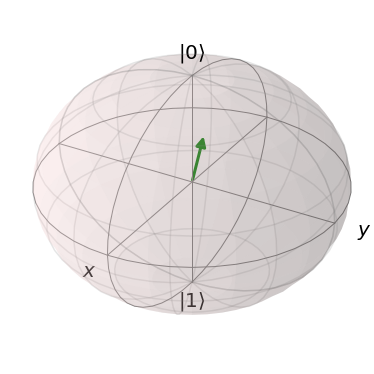

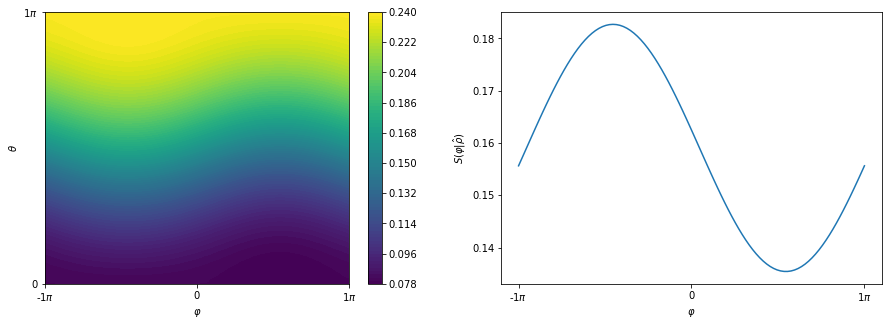

In [39]:
state = Qobj(state)

b = Bloch()
b.add_states(state)
b.show()

calc_and_plot_Q_and_S(state)

state

In [40]:
# correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method="least_squares")
tomo_state_mit = StateTomographyFitter(correct_tomo_results, qpt_circs)
state = tomo_state_mit.fit(method="lstsq")

# F_bell_mit = qi.state_fidelity(rho_fit_bell_mit, target_state_bell)
# print("State fidelity (w/ correction): F = {:.5f}".format(F_bell_mit))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.74141387+0.j         -0.02345321-0.02024588j]
 [-0.02345321+0.02024588j  0.25858613+0.j        ]]

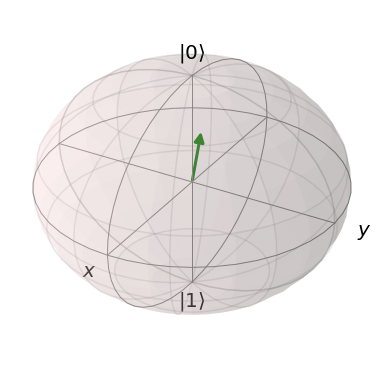

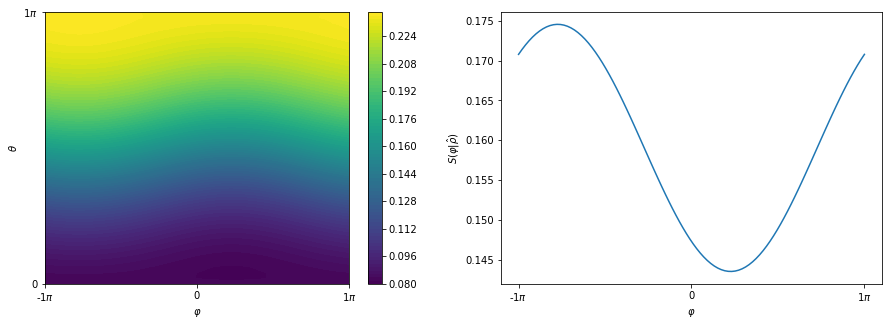

In [41]:
state = Qobj(state)

b = Bloch()
b.add_states(state)
b.show()

calc_and_plot_Q_and_S(state)

state

In [42]:
import qiskit.tools.jupyter
%qiskit_version_table